**Until now we assumed that we had a policy $\pi$ and we used that policy to estimate the state-value $V_{\pi}(x)$ function. What to do when we do not have a policy?**
* We, need to find the Q-values for each state-action pair.

**Why do we need the function $Q$ in MC methods, why can't we use function $V$?**
* In model-free reinforcement learning the values of the states are not sufficient to suggest a policy. One must explicitly estimate the values of each action, thus the primary goal in MC methods for control is to estimate the function $Q^{∗}$.

#### Monte-Carlo based Control (with Exploration Starts)

**Exploration start assumption**: Every episode start in a state-action pair ($x$,$a$) and every state-action pair [($x_{n}$,$a_{n} = Up$), ($x_{n}$,$a_{n} = Down$), ($x_{n}$,$a_{n} = left$), ($x_{n}$,$a_{n} = Right$)] $where $ ${n = 1,2,3....}$ has a non-zero probability of being selected as a **start**.


![](exploration_start.png)

State-action value matrix after 50000 iterations:
[[0.84703044 0.9064379  0.95759267 0.        ]
 [0.79726895 0.         0.69924677 0.        ]
 [0.7389757  0.68654985 0.61748781 0.40196111]] 

[[ 3.  3.  3. -1.]
 [ 0. nan  0. -1.]
 [ 0.  1.  0.  1.]]


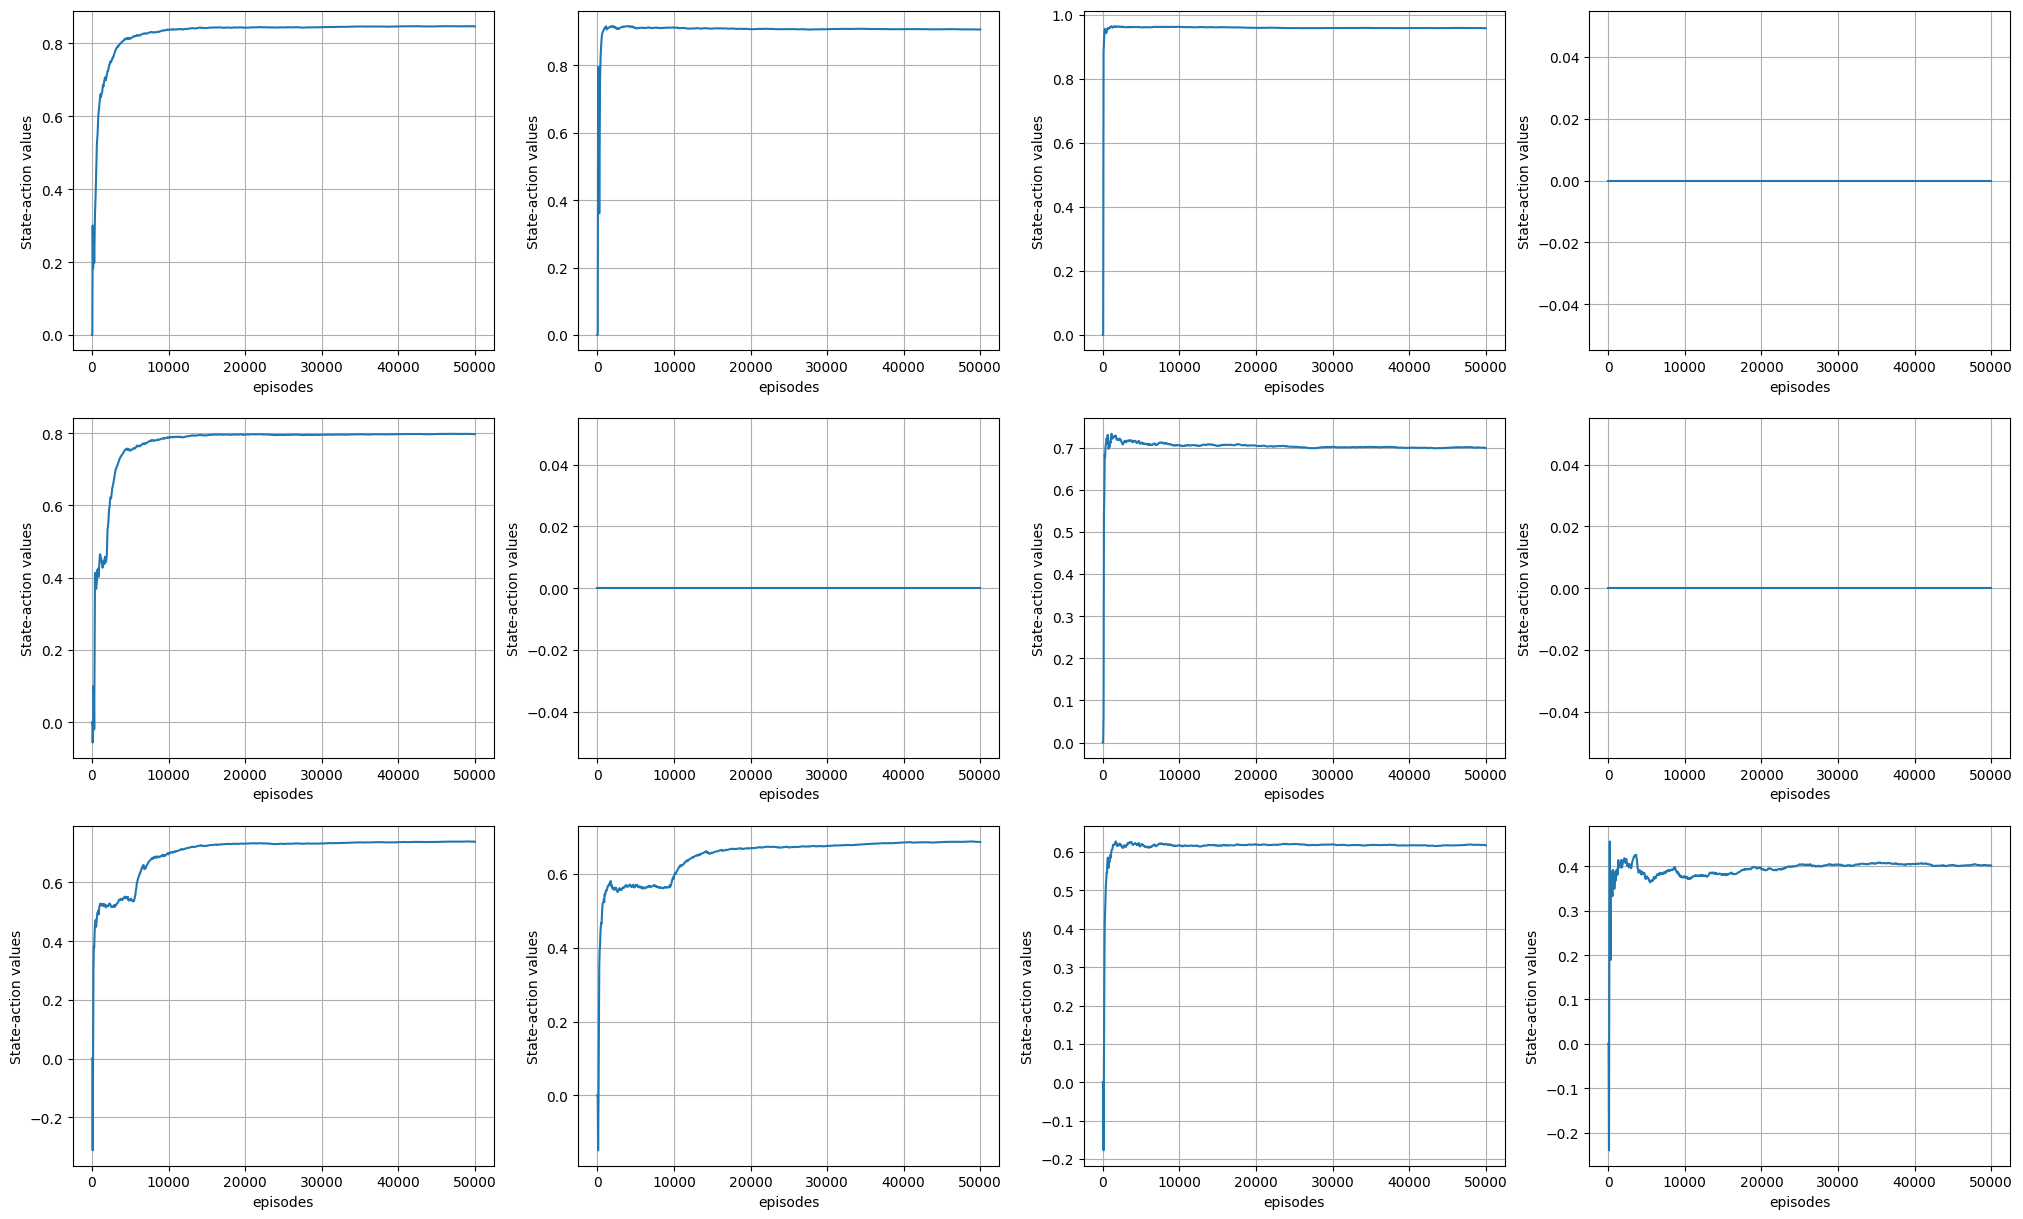

In [2]:
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
np.set_printoptions(suppress=True)  # to aviod scientific notation while printing numpy array
sys.path.append('..')

from environment import Gridworld

env = Gridworld()
gamma = 0.999 #discount factor

q = np.zeros((4, env.world_row*env.world_column)) # state-action value matrix
q_mean_matrix = np.full((4, env.world_row*env.world_column),1.0e-10) # init with 1 or very small value to avoid division by zero
q_plot = np.zeros((12,1)) # store data for plotting

# INPUT -> MC method is initialized with a RANDOM POLICY, {up=0, left=1, down=2, right=3}
policy = np.random.randint(0, 4, size=(env.world_row, env.world_column)).astype(np.float32) # Initial random Policy 
policy[1,1] = np.NaN # policy for block
policy[0,3] = -1 # policy for stairs
policy[1,3] = -1 # policy for goal state

tot_episodes = 50000 # no of eposides
time_step_for_task = 20 # time steps required to perform a task in one episode

for current_episode in range(tot_episodes):
    # The MC algorithm will converge to the optimal solution only if we assure exploring starts
    robot_current_state = env.reset(exploring_starts=True) # Reset and return the first observation

    episode_list = list() # Starting a new episode

    # Now we can run for some time step within the episode
    for step_time in range(time_step_for_task): 
        if step_time == 0:
            action = np.random.randint(0, 4) #If the episode just started then it is necessary to choose a random action (for exploring starts we need random state-action pair)
        else:
            action = policy[robot_current_state[0],robot_current_state[1]] # Next action from robot_state
        
        next_position = env.step(action) # perform this action
        
        state_reward = env.reward[next_position[0],next_position[1]] # state reward obtained

        # In episode list we need to store the observation at t, the action taken at t and the reward obtained at t+1
        episode_list.append((robot_current_state,action,state_reward)) # Append the visit in the episode list

        robot_current_state = next_position # Update robot current position (observation at t+1)

        if env.state_matrix[next_position[0],next_position[1]] == 1: # if in current episode, robot has reached the terimal state or stairs state then stop then reward calc in that episode
            break
        
    count = 0 # The episode is finished, now estimating the State-Value
    checkup_matrix = np.zeros((4, env.world_row*env.world_column)) # Checkup to identify if it is the first visit to a state

    # implementation of First-Visit MC 
    for visit in episode_list:
        y = (visit[0][0])*4 + visit[0][1] # storing position/observation from episode  
        x = int(visit[1])  # actions {up=0, left=1, down=2, right=3}

        if checkup_matrix[x,y] == 0: # For each state stored in the episode list, checks if it is the first visit and then estimates the return
            idx = 0
            reward_value = 0
            for i in episode_list[count:]:
                reward_value += i[2] * np.power(gamma,idx)
                idx += 1

            # counted which state is visited how many times (for averaging q) 
            if q_mean_matrix[x,y] == 1.0e-10:
                q_mean_matrix[x,y] = 1
            else:
                q_mean_matrix[x,y] += 1 
            
            q[x,y] = q[x,y] + (reward_value - q[x,y])/q_mean_matrix[x,y] # taking average and adding to current value

            checkup_matrix[x,y] = 1
        count += 1

    if current_episode % 50 == 0: # saving every 50th action-value
        q_plot = np.hstack((q_plot,np.amax(q, axis=0).reshape(12,1))) # save state values for graph plotting

    """Policy improvement is done by making the policy greedy with respect to the current state-action value and by choosing an action that maximize state-action value.
       A greedy algorithm makes the local optimal choice at each step. In our case greedy means to take, for each state, the action with the highest State-action 
       values -> np.argmax(q[all actions,state]) and update the policy with that action."""
    
    # Policy Update (Improvement)
    for visit in episode_list:
        [x,y] = visit[0]
        q_colm = (visit[0][0])*4 + visit[0][1] # storing position/observation from episode 
        if policy[x,y] != -1:
            policy[x,y] = np.argmax(q[:,q_colm]) # Policy Improvement is done by greedy-choices

# Arranging final state-action values in matrix form
q_final = np.zeros((env.world_row, env.world_column))
q_avg_final = np.amax(q, axis=0)
for j in range(env.world_row):
    for k in range(env.world_column):
        q_final[j,k] = q_avg_final[j*4 + k]

print("State-action value matrix after " + str(tot_episodes) + " iterations:")
print(q_final,'\n')
print(policy)

# Convergences Plot of state-values
plt.figure(figsize=(25,15))
for i in range(1, (env.world_row*env.world_column)+1):
    plt.subplot(env.world_row, env.world_column, i) # math.ceil() will round the value to upper limit
    plt.plot(np.arange(0, tot_episodes+1, 50), q_plot[i-1,:])
    plt.grid()
    plt.ylabel('State-action values')
    plt.xlabel('episodes')
plt.show()

#### Monte-Carlo based Control [without Exploring Starts by making policy soft (i.e, $\pi(a,x)>0$) using On-Policy Method i.e, $\epsilon$-greedy policy]
**To avoid the assumption of exploration start (While convenient for theoretical analysis, this is often impractical or unrealistic in real-world scenarios because some states or actions may not be reachable initially or may require specific conditions to occur), and ensure that all action are selected infinitely, we have 2 approaches on-policy and off-policy methods.**
* On-policy methods attempt to evaluate or improve the policy that is used to make decisions, whereas off-policy methods evaluate or improve a policy different from that used to generate the data.
* The Monte Carlo Exploration Start method developed above is an example of an on-policy method.
* In this section we show how an on-policy Monte Carlo **control** method can be designed that does not use the unrealistic assumption of exploring starts.
* In on-policy control methods the policy is generally soft, meaning that $\pi(u|x)$ > 0 for all $x \in \chi$ and all $u \in A(x)$, but gradually shifted closer and closer to a deterministic optimal policy.
* The on-policy method we present in this section uses $\epsilon-greedy$ policies.

![](soft_policy.png)

State-action value matrix after 50000 iterations:
[[0.78240677 0.85475021 0.93729093 0.        ]
 [0.71819736 0.         0.64584335 0.        ]
 [0.64511039 0.57513801 0.43853596 0.15412425]] 

[[ 3.  3.  3. -1.]
 [ 0. nan  0. -1.]
 [ 0.  1.  0.  1.]]


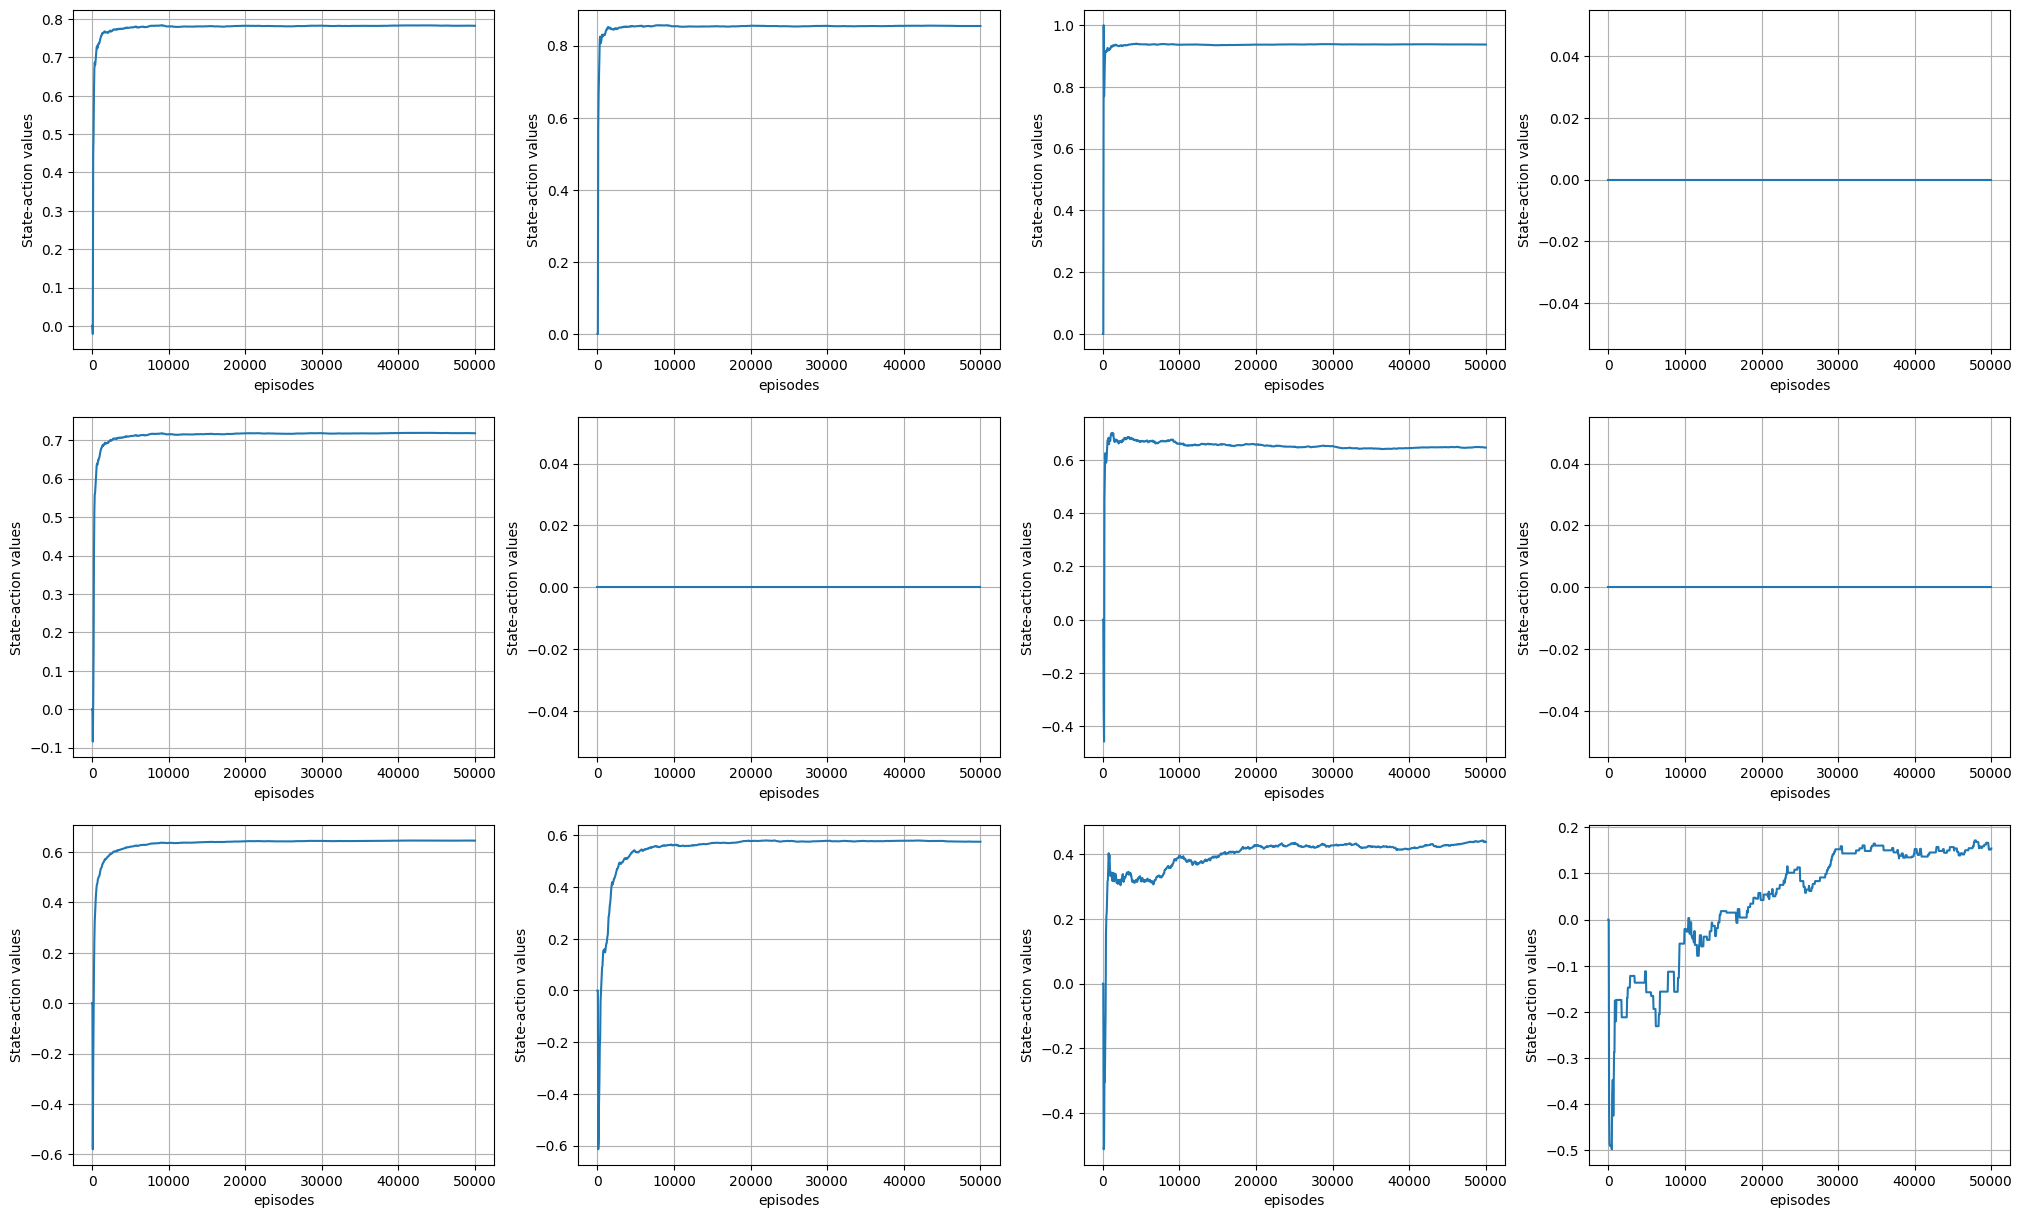

In [4]:
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
np.set_printoptions(suppress=True)  # to aviod scientific notation while printing numpy array
sys.path.append('..')

from environment import Gridworld

env = Gridworld()
gamma = 0.999 # discount factor
epsilon = 0.2

q = np.zeros((4, env.world_row*env.world_column)) # state-action value matrix
q_mean_matrix = np.full((4, env.world_row*env.world_column),1.0e-10) # init with 1 or very small value to avoid division by zero
q_plot = np.zeros((12,1)) # store data for plotting

# INPUT -> MC method is initialized with a random policy, {up=0, left=1, down=2, right=3}
policy = np.random.randint(0, 4, size=(env.world_row, env.world_column)).astype(np.float32) # Initial random Policy 
policy[1,1] = np.NaN # policy for block
policy[0,3] = -1 # policy for stairs
policy[1,3] = -1 # policy for goal state

non_greedy_prob = epsilon/env.no_action # Probability of each non-greedy action out of all non-greedy action
greedy_prob = 1 - epsilon + non_greedy_prob # Probability of greedy action

tot_episodes = 50000 # no of eposides
time_step_for_task = 20 # time steps required to perform a task in one episode

for current_episode in range(tot_episodes):
    robot_current_state = env.reset() # Reset and return the first observation
    episode_list = list() # Starting a new episode

    # Now we can run for some time step within the episode
    for step_time in range(time_step_for_task):  
        greedy_action = np.argmax(q[:,robot_current_state[0]*4 + robot_current_state[1]]) # action that has maximum estimated state-action value 

        # Take the action using epsilon-greedy
        weight_array = non_greedy_prob*np.ones((env.no_action)) # The weights of all non-greedy actions are equal to non-greedy probability
        weight_array[greedy_action] = greedy_prob # Now, we replace the weight of our greedy-action with greedy probability

        # Take the action using epsilon-greedy Policy
        """Choose an action that has maximal state-action value most of the time, but with probability ε select an action(out of all actions) at random"""
        action = int(np.random.choice(env.no_action,1,p=weight_array)) # u_{k} 

        next_position = env.step(action) # perform this action
        
        state_reward = env.reward[next_position[0],next_position[1]] # state reward obtained

        # In episode list we need to store the observation at t, the action taken at t and the reward obtained at t+1
        episode_list.append((robot_current_state,action,state_reward)) # Append the visit in the episode list

        robot_current_state = next_position # Update robot current position (observation at t+1)

        if env.state_matrix[next_position[0],next_position[1]] == 1: # if in current episode, robot has reached the terimal state or stairs state then stop then reward calc in that episode
            break
        
    count = 0 # The episode is finished, now estimating the State-Value
    checkup_matrix = np.zeros((4, env.world_row*env.world_column)) # Checkup to identify if it is the first visit to a state

    # implementation of First-Visit MC 
    for visit in episode_list:
        y = (visit[0][0])*4 + visit[0][1] # storing position/observation from episode  
        x = int(visit[1]) # actions {up=0, left=1, down=2, right=3}

        if checkup_matrix[x,y] == 0: # For each state stored in the episode list, checks if it is the first visit and then estimates the return
            idx = 0
            reward_value = 0
            for i in episode_list[count:]:
                reward_value += i[2] * np.power(gamma,idx)
                idx += 1

            # counted which state is visited how many times (for averaging q) 
            if q_mean_matrix[x,y] == 1.0e-10:
                q_mean_matrix[x,y] = 1
            else:
                q_mean_matrix[x,y] += 1 
            
            q[x,y] = q[x,y] + (reward_value - q[x,y])/q_mean_matrix[x,y] # taking average and adding to current value

            checkup_matrix[x,y] = 1
        count += 1

    if current_episode % 50 == 0: # saving every 50th action-value
        q_plot = np.hstack((q_plot,np.amax(q, axis=0).reshape(12,1))) # save state values for graph plotting

    # Policy Improvement -> Use greedy approach to improve policy after each episode (choose an action with a maximum state-action value)
    for visit in episode_list:
        [x,y] = visit[0]
        q_colm = (visit[0][0])*4 + visit[0][1] # storing position/observation from episode 
        if policy[x,y] != -1:
            policy[x,y] = int(visit[1]) # Policy Improvement is done by greedy-choices 
    
    """A greedy algorithm makes the local optimal choice at each step. In our case greedy means to take, for each state, the action with 
    the highest State-action values -> np.argmax(q[all actions,state]) and update the policy with that action."""

# Arranging final state-action values in matrix form
q_final = np.zeros((env.world_row, env.world_column))
q_avg_final = np.amax(q, axis=0)
for j in range(env.world_row):
    for k in range(env.world_column):
        q_final[j,k] = q_avg_final[j*4 + k]

print("State-action value matrix after " + str(tot_episodes) + " iterations:")
print(q_final,'\n')
print(policy)

# Convergences Plot of state-values
plt.figure(figsize=(25,15))
for i in range(1, (env.world_row*env.world_column)+1):
    plt.subplot(env.world_row, env.world_column, i) # math.ceil() will round the value to upper limit
    plt.plot(np.arange(0, tot_episodes+1, 50), q_plot[i-1,:])
    plt.grid()
    plt.ylabel('State-action values')
    plt.xlabel('episodes')
plt.show()